In [1]:
import json
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap
from matplotlib.image import imread
from deepspectrumlite import AugmentableModel, ARelu
from keras.preprocessing.image import load_img, img_to_array
import os
import sys
from tqdm import tqdm
from tensorflow.keras import utils

2022-02-17 16:56:34.108256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 16:56:34.108337: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Initial path adjustment

In [2]:
# name of the dataset
dataset='ccs'
# root directory, including folders for the trained model (*.h5) file(s) and spectrogram plots
root='./'
# path to the model directory
model_path=os.path.join(root,'model')
# path to the spectrogram plots. For each class of your dataset, create a folder that includes a spectrogram plot (.png) of that class.
spec_path=os.path.join(root,'spectrograms')
# final model path
source = os.path.join(model_path,dataset,'model.h5')

Load the trained model with custom objects

In [3]:
model = tf.keras.models.load_model(source,
                                           custom_objects={'AugmentableModel': AugmentableModel, 'ARelu': ARelu},
                                           compile=False)

2022-02-17 16:56:38.320274: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-17 16:56:38.350236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 16:56:38.350539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3c:00.0 name: NVIDIA GeForce MX250 computeCapability: 6.1
coreClock: 1.582GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 52.21GiB/s
2022-02-17 16:56:38.350701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 16:56:38.350817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'l

Configuration of sample datasets

In [4]:
if dataset=='ravdess':
    class_names = ['Angry', 'Calm', 'Fearful', 'Happy', 'Neutral', 'Sad']
    n_classes = len(class_names)
elif dataset=='snore':
    class_names = ['Velum', 'Oropharyngeal', 'Tongue base', 'Epiglottis']
    n_classes = len(class_names)
elif dataset=='sleep':
    class_names = ['Non-Sleepy', 'Sleepy']
    n_classes = len(class_names)
elif dataset=='ccs' or dataset=='css':
    class_names = ['Negative', 'Positive']
    n_classes = len(class_names)

In [5]:
# python function to get model output; replace this function with your own model function.

def f(x):
    tmp = x.copy()
    tmp = tf.keras.applications.densenet.preprocess_input(tmp)
    return model(tmp)

Running SHAP experiments

test_010.png
test_039.png


2022-02-17 16:56:51.001331: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33269760 exceeds 10% of free system memory.
2022-02-17 16:56:52.765768: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33269760 exceeds 10% of free system memory.
  0%|          | 0/48 [00:00<?, ?it/s]2022-02-17 16:56:54.613861: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33269760 exceeds 10% of free system memory.
50it [00:01, 26.59it/s]               2022-02-17 16:56:56.271215: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33269760 exceeds 10% of free system memory.
Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]2022-02-17 16:57:02.074778: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33269760 exceeds 10% of free system memory.
Partition explainer: 3it [00:24, 12.18s/it]               


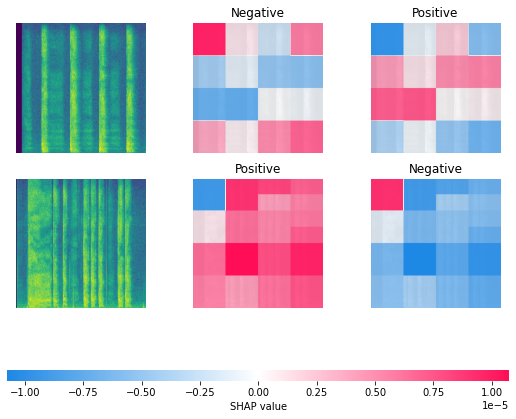

In [6]:
file_path=os.path.join(spec_path,dataset,class_names[0])
X = []
for c in class_names:
    file_path=os.path.join(spec_path,dataset,c)
    filename=os.listdir(file_path)[0]
    print(filename)
    if filename.endswith('.png'):
        original = img_to_array(load_img(os.path.join(file_path,filename), target_size = (224, 224)))
        X.append(original)
X = np.array(X)
# define a masker that is used to mask out partitions of the input image.
inpaint_mode = 'inpaint_telea' # inpaint_telea
masker = shap.maskers.Image(inpaint_mode, X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain n (=number of classes) images using 100 evaluations of the underlying model to estimate the SHAP values
max_eval_val = 100
shap_values = explainer(X, max_evals=max_eval_val, batch_size=10, outputs=shap.Explanation.argsort.flip[:n_classes])
shap.image_plot(shap_values, show=False)

# save the SHAP output as pdf
shap_output=os.path.join(root,'shap',dataset,str(max_eval_val))
if not os.path.exists(shap_output):
    os.makedirs(shap_output)
plt.savefig(os.path.join(shap_output, f'shap_{dataset}_{max_eval_val}.pdf'), bbox_inches='tight')